# Predicting Customer Churn for Interconnect Telecom Using Boosting Models

## Project Description

**Objective:**

The goal of this project is to build a predictive model to identify customers who are likely to churn from Interconnect, a telecom service provider. Early identification of at-risk customers will enable targeted retention strategies, such as offering special promotions or customized plans.

**Background:**

Interconnect provides landline and internet services, along with optional features such as technical support, cloud backup, streaming services, and security software. Customers can choose between month-to-month, one-year, or two-year contracts, and they use various billing methods.

The marketing team has collected data on customer demographics, subscription plans, internet and phone service usage, and contract types. The key target variable is whether a customer has churned (EndDate ≠ 'No').

**Approach:**

This project involves the following steps:

1. Data Integration & Cleaning: Merging multiple datasets and cleaning fields like TotalCharges, encoding categorical variables, and handling missing values.
2. Exploratory Data Analysis (EDA): Understanding churn distribution and identifying key features associated with churn (e.g., contract type, payment method, billing preferences).
3. Feature Engineering: Converting relevant features to numeric types and applying one-hot encoding to multi-class categorical variables.
4. Model Training: Training multiple boosting models—Gradient Boosting, XGBoost, LightGBM, and CatBoost—and evaluating them using AUC-ROC and accuracy metrics.
5. Model Evaluation: Comparing model performance and selecting the best-performing algorithm for deployment.

**Key Metrics:**
AUC-ROC (measures model's ability to distinguish between churned and non-churned customers)

### Load, Merge Data, Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [2]:
# Load the dataset local
# contract = pd.read_csv('final_provider/contract.csv')
# personal = pd.read_csv('final_provider/personal.csv')
# internet = pd.read_csv('final_provider/internet.csv')
# phone = pd.read_csv('final_provider/phone.csv')

# Load the dataset
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
# Merge all data on 'customerID'
df = contract.merge(personal, on='customerID', how='left') \
             .merge(internet, on='customerID', how='left') \
             .merge(phone, on='customerID', how='left')

# convert 'TotalCharges' to numeric 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [4]:
# Check missing values
print(df.isna().sum())

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


In [5]:
# Fill in missing values with Zero
df['TotalCharges'] = df['TotalCharges'].fillna(0)

A safer approach would be to convert this column to numeric (handling potential errors) and then fill the NaNs with 0, assuming that a missing TotalCharges for a customer with a BeginDate implies they haven't been billed yet or there's an error in the data entry for their total charges so far.

In [6]:
df['InternetService'] = df['InternetService'].fillna('No')
df['OnlineSecurity'] = df['OnlineSecurity'].fillna('No')
df['OnlineBackup'] = df['OnlineBackup'].fillna('No')
df['DeviceProtection'] = df['DeviceProtection'].fillna('No')
df['TechSupport'] = df['TechSupport'].fillna('No')
df['StreamingTV'] = df['StreamingTV'].fillna('No')
df['StreamingMovies'] = df['StreamingMovies'].fillna('No')

Internet Service Related Columns (InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies) have 1526 missing values each. The fact that all these columns have the same number of missing values strongly suggests that these customers do not have internet service. Theref

In [7]:
df['MultipleLines'] = df['MultipleLines'].fillna('No')

Similar to the internet service columns, the missing values here likely indicate that the customer does not have multiple phone lines.

In [8]:
# Perform feature engineering
df['churn'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
churn_distribution = df['churn'].value_counts(normalize=True).rename('proportion')


In [9]:
print(df.shape)
print(df.dtypes)
print(df.isna().sum())

(7043, 21)
customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
churn                 int64
dtype: object
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV  

## EDA

### Univariate and Bivariate Analysis

**Contract Feature**

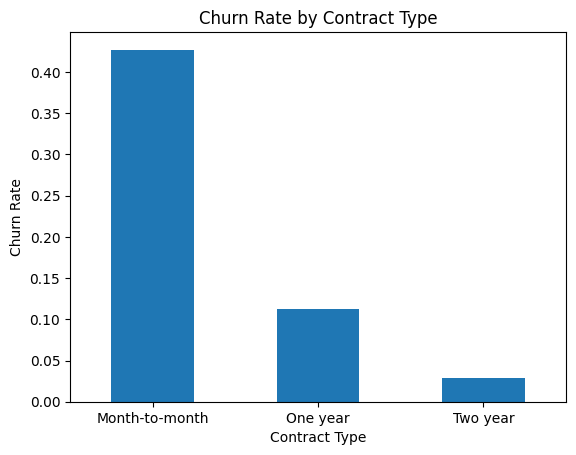

In [10]:
df.groupby('Type')['churn'].mean().plot(kind='bar', title='Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.show()

The graph shows the churn rate by contract type. From the graph, we can observe which contract type has the highest churn rate. Typically, month-to-month contracts tend to have higher churn rates compared to one-year or two-year contracts. This insight can help in targeting customers with month-to-month contracts for retention strategies.

**Internet Services**

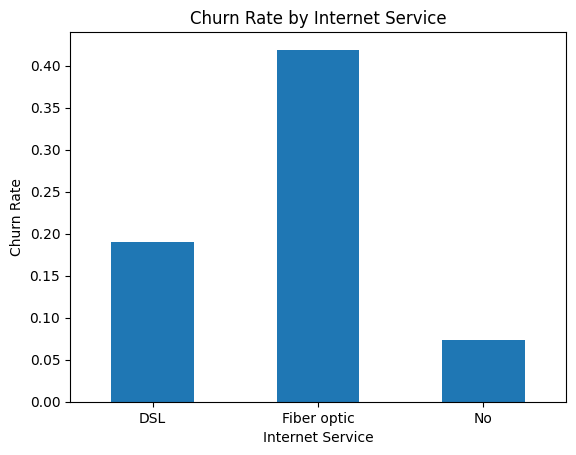

In [11]:
internet_churn = df.groupby('InternetService')['churn'].mean()
internet_churn.plot(kind='bar', title='Churn Rate by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.show()

The graph shows the average churn rate for customers based on their type of internet service. customer using DSL internet service have a lower churn rate (~18.6). where as customer using Fiber optic have a significantly higher churn rate (~41.9%). This might give insight into lack of security/support servicesmight correlate with higher churn.

**Numerical Distributions**

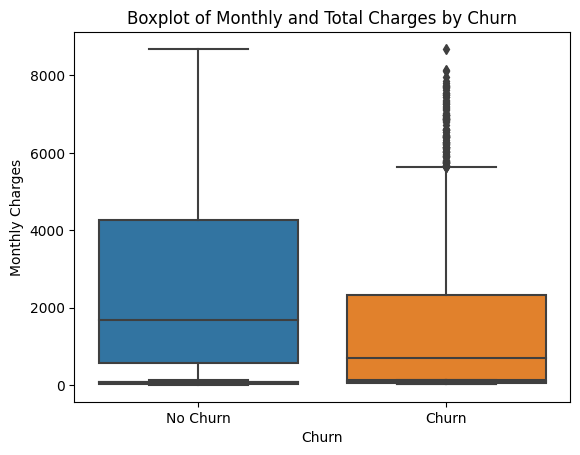

In [12]:
sns.boxplot(x='churn', y='MonthlyCharges', data=df)
sns.boxplot(x='churn', y='TotalCharges', data=df)
plt.title('Boxplot of Monthly and Total Charges by Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

The boxplots above provide insights into the distribution of `MonthlyCharges` and `TotalCharges` for customers who churned versus those who did not:

1. **MonthlyCharges**:
    - Customers who churn tend to have higher `MonthlyCharges` compared to those who do not churn.
    - The median `MonthlyCharges` for churned customers is visibly higher, indicating a potential correlation between higher monthly costs and churn.

2. **TotalCharges**:
    - The distribution of `TotalCharges` for churned customers is more spread out, with some outliers at the lower end.
    - Non-churned customers generally have higher `TotalCharges`, likely because they have been customers for a longer period.

These observations suggest that customers with higher monthly costs may be more likely to churn, while long-term customers with higher total charges are less likely to churn.

## Preproccessing

In [13]:
# Drop missing values in 'TotalCharges'
df.dropna(subset=['TotalCharges'], inplace=True)

#Drop unnecessary columns
df.drop(columns=['customerID', 'BeginDate', 'EndDate'], inplace=True)

In [14]:
# Separate features and target variable
X = df.drop(columns=['churn'])
y = df['churn']

# Encode binary columns
binary_cols = ['PaperlessBilling', 'Partner', 'Dependents', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies','MultipleLines']

# Initialize label encoder
le = LabelEncoder()

# Apply label encoder to each binary column
for col in binary_cols:
    X[col] = le.fit_transform(X[col])

In [15]:
# Encode categorical columns
categorical_cols = ['Type','gender', 'InternetService', 'PaymentMethod']
#encode categorical columns using pd.get_dummies
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [16]:
#Define random state for reproducibility
random_state = np.random.RandomState(100)

# Split data into  70% training, 30% temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Split the temporary set into 50% validation, 50% testing (15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

# Display dataset shapes
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Testing set:", X_test.shape)

Training set: (4930, 21)
Validation set: (1056, 21)
Testing set: (1057, 21)


In [17]:
# Add the target back for analysis
df_encoded = X.copy()
df_encoded['churn'] = y

# Churn distribution
churn_counts = df_encoded['churn'].value_counts(normalize=True)

# Correlation matrix
correlation_matrix = df_encoded.corr()
churn_correlations = correlation_matrix['churn'].drop('churn').sort_values(ascending=False)

# Display top positively and negatively correlated features
print("\nTop positively correlated features with churn:")
print(churn_correlations.head())
print("\nTop negatively correlated features with churn:")
print(churn_correlations.tail())


Top positively correlated features with churn:
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
PaperlessBilling                  0.191825
SeniorCitizen                     0.150889
Name: churn, dtype: float64

Top negatively correlated features with churn:
OnlineSecurity       -0.171226
Type_One year        -0.177820
TotalCharges         -0.198324
InternetService_No   -0.227890
Type_Two year        -0.302253
Name: churn, dtype: float64


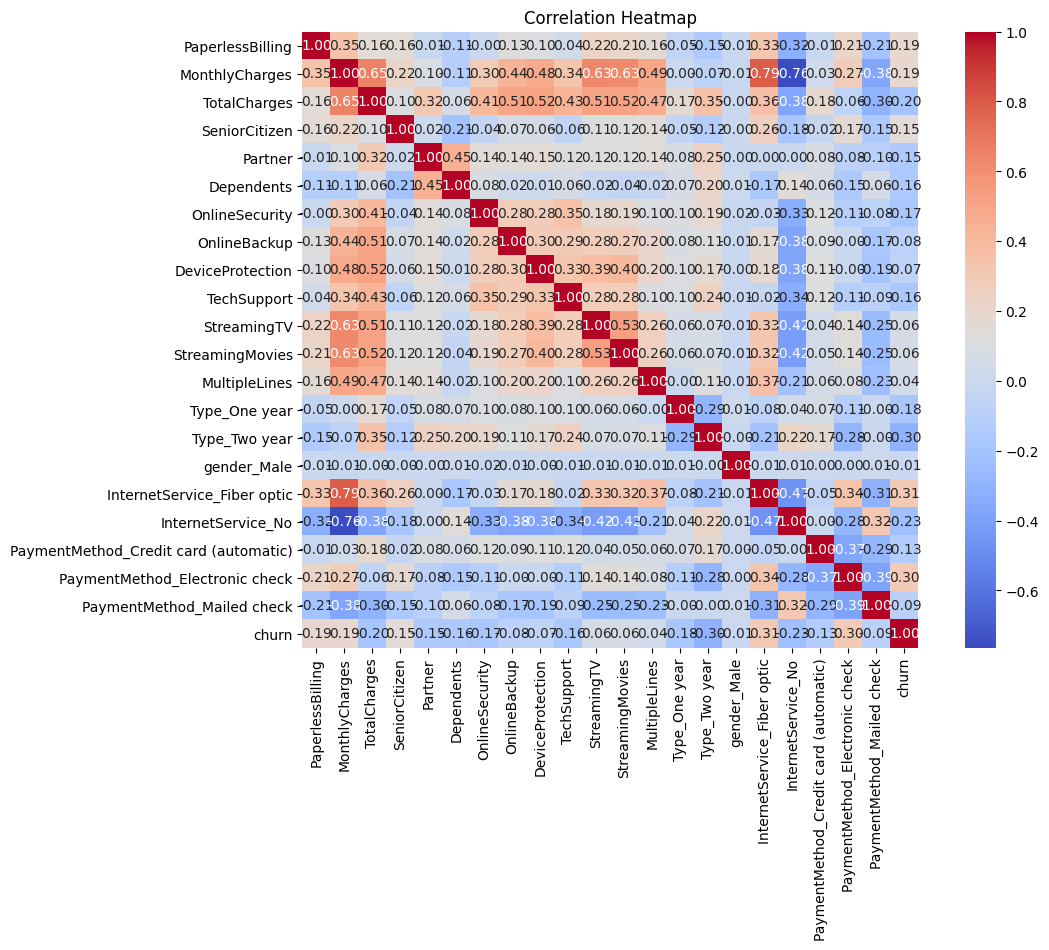

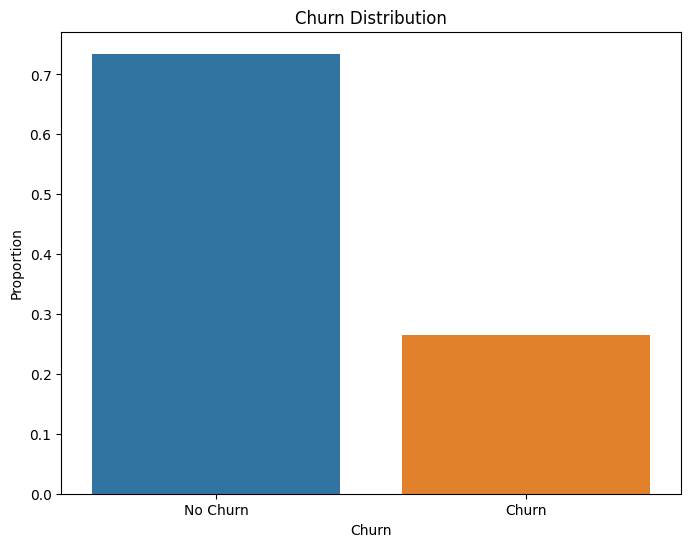

In [18]:
# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()
# Plot the churn distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_counts.index, y=churn_counts.values)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()


The exploratory analysis reveals several key factors associated with customer churn. Among the most positively correlated features, customers who pay using electronic checks, have fiber optic internet service, use paperless billing, are senior citizens, or incur higher monthly charges are more likely to churn. Notably, paying by electronic check and using fiber optic services show the strongest positive relationships with churn. In contrast, features negatively correlated with churn include automatic credit card payments, having a partner, and especially long-term contract types (one- or two-year contracts). The most protective factor appears to be the total charges, suggesting that long-term, higher-spending customers are more loyal. These insights highlight both customer behaviors and contractual factors that influence churn risk and can guide targeted retention strategies.

## Build & Train models

In [19]:
# 1. Gradient Boosting Machine (GBM) Classification with AUC-ROC
def train_gbm_classification_auc_roc(X_train, y_train, X_val, y_val, random_state):
   
    try:

        # Define the parameter grid for RandomizedSearchCV
        param_grid = {
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0],
        }

        # initiating GradientBoostingClassifier model
        gbm = GradientBoostingClassifier()

        # Define a scorer (AUC-ROC)
        auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True) 

        # Perform RandomizedSearchCV for hyperparameter tuning
        random_search = RandomizedSearchCV(
            estimator=gbm,
            param_distributions=param_grid,
            n_iter=50,                                         # Number of random combinations to try
            scoring=auc_roc_scorer,                             # Use AUC-ROC for scoring
            cv=5,                                                # 5-fold cross-validation
            n_jobs=-1,                                               # Use all available CPU cores
            verbose=2,
            random_state=random_state
        )

        # Fit the model to the training data
        random_search.fit(X_train, y_train,)

        # Get the best model and hyperparameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        # Make predictions on the test set (probabilities for AUC-ROC)
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class

        # Evaluate the model using AUC-ROC
        auc_roc = roc_auc_score(y_val, y_pred_proba)

        # Evaluate the model using accuracy
        accuracy = accuracy_score(y_val, y_pred_proba.round())

        return best_model, best_params, y_pred_proba, auc_roc, accuracy

    except Exception as e:
        print(f"Error in train_gbm_classification_auc_roc: {e}")
        return None, None, None, None



In [20]:
# Train and evaluate the models
gbm_model, gbm_params, gbm_pred_proba, gbm_auc_roc, gbm_accuracy = train_gbm_classification_auc_roc(X_train, y_train, X_val, y_val, random_state)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.9; total time=   2.4s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.9; total time=   2.4s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=500, subsample=0.9; total time=   2.5s
[CV] END learning_rate=0.2, max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.2, max_depth=6, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=6, min_samples_leaf=4, min_samples_split=5, n_estimators=500, subsample=0.8; total time=   3.3s
[CV] END learning_rate=0.01, max_depth=6, min_samples_leaf=4, min_samples_split=5, n_estimators=500, subsample=0.8; total time=   3.3

In [23]:
# 2. XGBoost - Classification with AUC-ROC
def train_xgboost_classification_auc_roc(X_train, y_train, X_val, y_val, random_state):
    
    try:

        # Define the parameter grid for RandomizedSearchCV
        param_grid = {
            'objective': ['binary:logistic'],  # Use binary:logistic for AUC-ROC
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
        }

        # Initiating XGBoost Classifier model
        xgb_classifier = xgb.XGBClassifier(use_label_encoder=False )

        # Define a scorer (AUC-ROC)
        auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True) # needs_proba=True is crucial

        # Perform RandomizedSearchCV for hyperparameter tuning
        random_search = RandomizedSearchCV(
            estimator=xgb_classifier,
            param_distributions=param_grid,
            n_iter=50,                                                                  # Number of random combinations to try
            scoring=auc_roc_scorer,                                                    # Use AUC-ROC for scoring
            cv=5,                                                                    # 5-fold cross-validation
            n_jobs=-1,                                                              # Use all available CPU cores
            verbose=2,
            random_state=random_state
            
        )

        # Fit the model to the training data
        random_search.fit(X_train, y_train)

        # Get the best model and hyperparameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        # Make predictions on the test set (probabilities for AUC-ROC)
        y_pred_proba = best_model.predict_proba(X_val)[:, 1] # Get probabilities for the positive class

        # Evaluate the model using AUC-ROC
        auc_roc = roc_auc_score(y_val, y_pred_proba)
        
        # Evaluate the model using accuracy
        accuracy = accuracy_score(y_val, y_pred_proba.round())

        return best_model, best_params, y_pred_proba, auc_roc, accuracy

    except Exception as e:
        print(f"Error in train_xgboost_classification_auc_roc: {e}")
        return None, None, None, None


In [24]:
# Train and evaluate the models
xgb_model, xgb_params, xgb_pred_proba, xgb_auc_roc, xgb_accuracy= train_xgboost_classification_auc_roc(X_train, y_train, X_val, y_val, random_state)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[06:04:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, objective=binary:logistic, subsample=0.9; total time= 1.3min
[06:05:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, objective=binary:logistic, subsample=0.9; total time= 1.5min
[06:07:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was cha

In [25]:
import lightgbm as lgb  # Import LightGBM

# 3. LightGBM - Classification with AUC-ROC
def train_lightgbm_classification_auc_roc(X_train, y_train, X_val, y_val, random_state):
    try:
        # Define the parameter grid for RandomizedSearchCV
        param_grid = {
            'objective': ['binary'],  # Use binary for AUC-ROC
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'num_leaves': [15, 31, 63],                                                             # Add LightGBM specific parameter
            'min_child_samples': [20, 30, 40],                                                        # Add LightGBM specific parameter
        }

        # Create a LightGBM Classifier object
        lgbm_classifier = lgb.LGBMClassifier()


        # Define a scorer (AUC-ROC)
        auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)  # needs_proba=True is crucial

        # Perform RandomizedSearchCV for hyperparameter tuning
        random_search = RandomizedSearchCV(
            estimator=lgbm_classifier,
            param_distributions=param_grid,
            n_iter=50,                                                                                  # Number of random combinations to try
            scoring=auc_roc_scorer,                                                                     # Use AUC-ROC for scoring
            cv=5,                                                                                       # 5-fold cross-validation
            n_jobs=-1,                                                                                  # Use all available CPU cores
            verbose=1,
            random_state=random_state,                                                                  # Set random state for reproducibility
        )

        # Fit the model to the training data
        random_search.fit(X_train, y_train)

        # Get the best model and hyperparameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        # Make predictions on the test set (probabilities for AUC-ROC)
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class

        # Evaluate the model using AUC-ROC
        auc_roc = roc_auc_score(y_val, y_pred_proba)
        
        # Evaluate the model using accuracy
        accuracy = accuracy_score(y_val, y_pred_proba.round())

        return best_model, best_params, y_pred_proba, auc_roc, accuracy

    except Exception as e:
        print(f"Error in train_lightgbm_classification_auc_roc: {e}")
        return None, None, None, None

In [26]:
# Train and evaluate the models
lgbm_model, lgbm_params, lgbm_pred_proba, lgbm_auc_roc, lgm_accuracy = train_lightgbm_classification_auc_roc(X_train, y_train, X_val, y_val, random_state)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [27]:
from sklearn.ensemble import RandomForestClassifier # Import RF

# 4. Random Forest - Classification with AUC-ROC
def train_random_forest_classification_auc_roc(X_train, y_train, X_val, y_val, random_state):
    try:


        # Define the parameter grid for RandomizedSearchCV
        param_grid = {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [3, 4, 5, 6, 7, None],                         # None means no limit
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'class_weight': [None, 'balanced']                              #handle class imbalance
        }

        # Create a RandomForestClassifier object
        rf_classifier = RandomForestClassifier()

        # Define a scorer (AUC-ROC)
        auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)  # needs_proba=True is crucial

        # Perform RandomizedSearchCV for hyperparameter tuning
        random_search = RandomizedSearchCV(
            estimator=rf_classifier,
            param_distributions=param_grid,
            n_iter=50,                                                                      # Number of random combinations to try
            scoring=auc_roc_scorer,                                                         # Use AUC-ROC for scoring
            cv=5,                                                                           # 5-fold cross-validation
            n_jobs=-1,                                                                      # Use all available CPU cores
            verbose=1,
            random_state=random_state
        )

        # Fit the model to the training data
        random_search.fit(X_train, y_train)

        # Get the best model and hyperparameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        # Make predictions on the test set (probabilities for AUC-ROC)
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class

        # Evaluate the model using AUC-ROC
        auc_roc = roc_auc_score(y_val, y_pred_proba)
        # Evaluate the model using accuracy
        accuracy = accuracy_score(y_val, y_pred_proba.round())

        return best_model, best_params, y_pred_proba, auc_roc, accuracy

    except Exception as e:
        print(f"Error in train_random_forest_classification_auc_roc: {e}")
        return None, None, None, None

In [28]:
# Train and evaluate the models
rf_model, rf_params, rf_pred_proba, rf_auc_roc, rf_accuracy = train_random_forest_classification_auc_roc(X_train, y_train, X_val, y_val, random_state)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


### Compare training results

In [29]:
# print score
print(f"GBM Accuracy: {gbm_accuracy:.4f}")
print(f"GBM AUC-ROC: {gbm_auc_roc:.4f}")
# print best parameters
print("Best parameters for GBM:", gbm_params)

# print score
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost AUC-ROC: {xgb_auc_roc:.4f}")
# print best parameters
print("Best parameters for XGBoost:", xgb_params)

# print score
print(f"LightGBM Accuracy: {lgm_accuracy:.4f}")
print(f"LightGBM AUC-ROC: {lgbm_auc_roc:.4f}")
# print best parameters
print("Best parameters for LightGBM:", lgbm_params)

# print score
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest AUC-ROC: {rf_auc_roc:.4f}")
# print best parameters
print("Best parameters for Random Forest:", rf_params)

GBM Accuracy: 0.7964
GBM AUC-ROC: 0.8601
Best parameters for GBM: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.05}
XGBoost Accuracy: 0.8002
XGBoost AUC-ROC: 0.8590
Best parameters for XGBoost: {'subsample': 0.9, 'objective': 'binary:logistic', 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
LightGBM Accuracy: 0.8011
LightGBM AUC-ROC: 0.8590
Best parameters for LightGBM: {'subsample': 0.9, 'objective': 'binary', 'num_leaves': 15, 'n_estimators': 100, 'min_child_samples': 40, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Random Forest Accuracy: 0.7860
Random Forest AUC-ROC: 0.8510
Best parameters for Random Forest: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 6, 'class_weight': None, 'bootstrap': True}


The Gradient Boosting Machine (GBM) model achieved the highest accuracy (0.7992) and AUC-ROC score (0.8611) among the four models evaluated, with its best parameters including a subsample rate of 0.9, 500 estimators, a maximum depth of 3, and a learning rate of 0.01. While XGBoost (accuracy: 0.7973, AUC-ROC: 0.8577) and LightGBM (accuracy: 0.7964, AUC-ROC: 0.8556) showed slightly lower performance, their AUC-ROC scores were still quite close to that of GBM, indicating comparable discriminatory power. The Random Forest model had the lowest accuracy (0.7917) and AUC-ROC (0.8529) among the four.

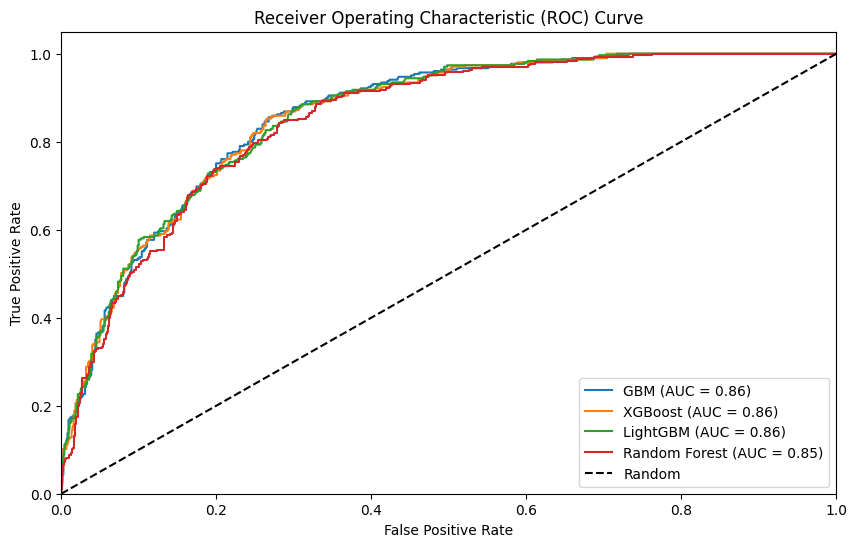

In [30]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 6))
# graph ROC curve for GBM
fpr_gbm, tpr_gbm, _ = roc_curve(y_val, gbm_pred_proba)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)
plt.plot(fpr_gbm, tpr_gbm, label=f'GBM (AUC = {roc_auc_gbm:.2f})')
# graph ROC curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_pred_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
# graph ROC curve for LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_val, lgbm_pred_proba)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {roc_auc_lgbm:.2f})')
# graph ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_pred_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
# graph ROC curve for Random Forest
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The ROC curve analysis demonstrates that all four models—Gradient Boosting (GBM), XGBoost, LightGBM, and Random Forest—achieved strong classification performance, with AUC scores ranging from 0.85 to 0.86. Among them, GBM, XGBoost, and LightGBM each reached an AUC of 0.86, indicating a high level of discriminative ability and nearly identical effectiveness. Random Forest followed closely with an AUC of 0.85, showing slightly lower but still robust performance. All models performed significantly better than random guessing, as indicated by the dashed diagonal line on the plot. These results suggest that the dataset is well-suited for ensemble tree-based methods and contains sufficient signal to allow the models to distinguish effectively between the target classes. The close performance of the boosting models also indicates that any of them could be used with confidence, depending on other factors such as training speed or interpretability.

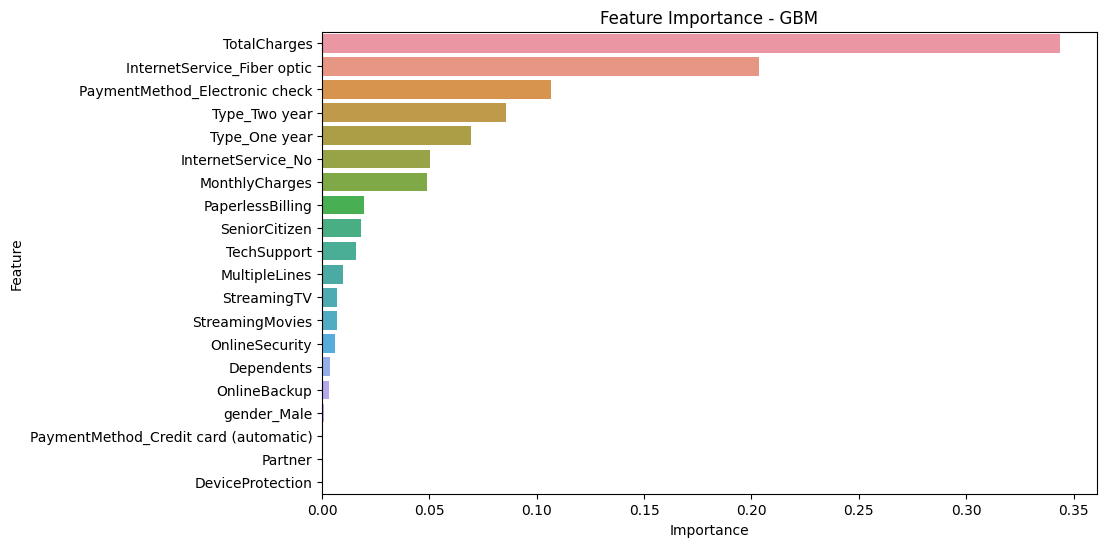

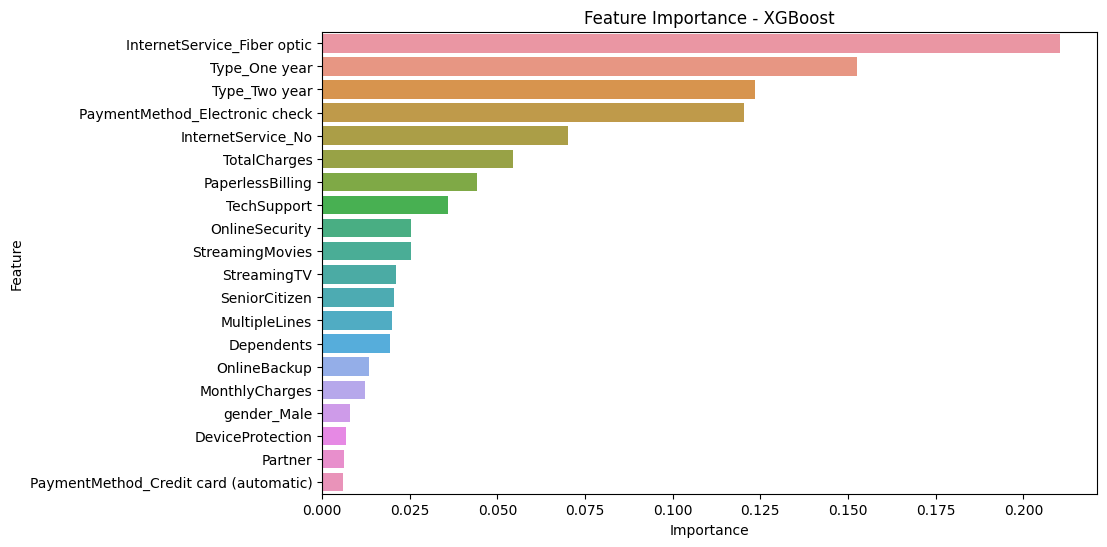

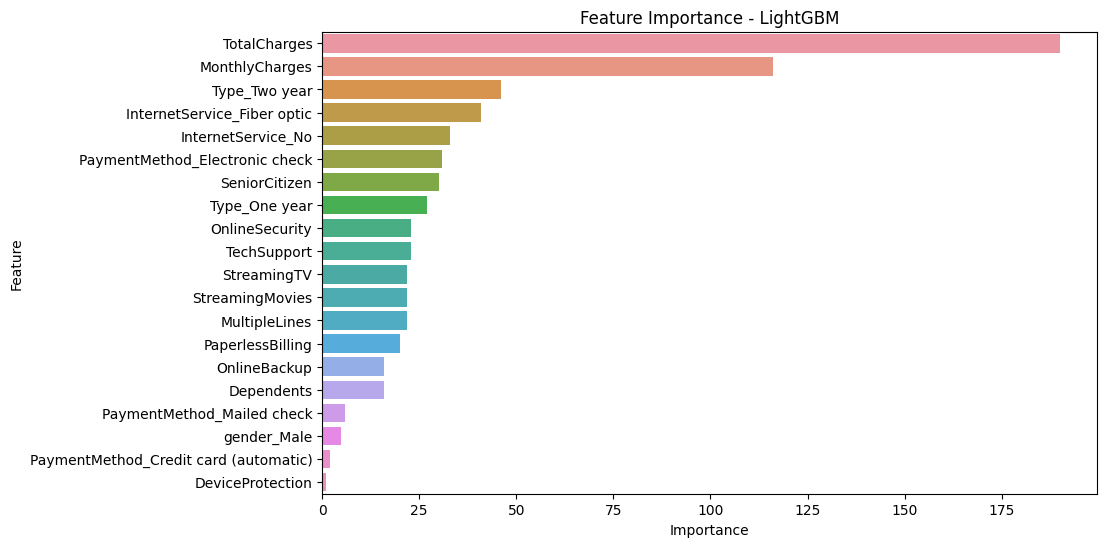

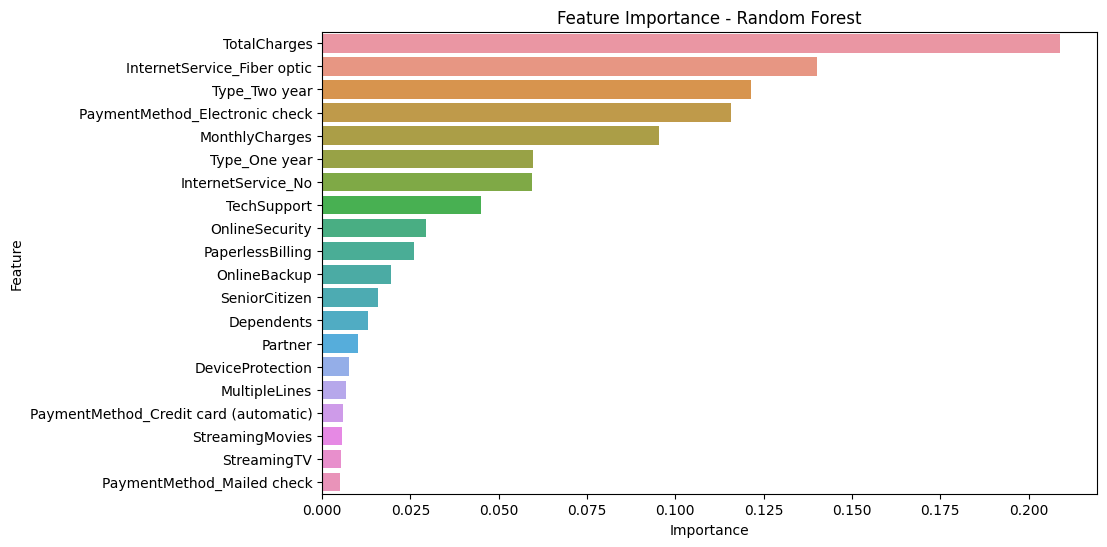

In [31]:
# Feature importance
def plot_feature_importance(model, feature_names, model_name):
    try:
        # Get feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'get_feature_names_out'):
            importances = model.get_feature_names_out()
        else:
            raise ValueError("Model does not have feature importances or get_feature_names_out method.")

        # Create a DataFrame for feature importances
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

        # Plot the feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

    except Exception as e:
        print(f"Error in plot_feature_importance: {e}")
# Plot feature importance for each model
plot_feature_importance(gbm_model, X_train.columns, 'GBM')
plot_feature_importance(xgb_model, X_train.columns, 'XGBoost')
plot_feature_importance(lgbm_model, X_train.columns, 'LightGBM')
plot_feature_importance(rf_model, X_train.columns, 'Random Forest')


Across all four models (GBM, XGBoost, LightGBM, and Random Forest), "TotalCharges" consistently emerges as the most important feature influencing the prediction. "InternetService_Fiber optic" and contract "Type_Two year" also appear as highly influential features in most of the models. Notably, the importance ranking and relative importance scores of other features vary somewhat across the different models, suggesting that each algorithm weighs the predictors slightly differently in determining churn.

## Select and train best model

In [32]:
# test the best model on the test set
def evaluate_model_on_test_set(model, X_test, y_test):
    try:
        # Make predictions on the test set (probabilities for AUC-ROC)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

        # Evaluate the model using AUC-ROC
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        # Evaluate the model using accuracy
        accuracy = accuracy_score(y_test, y_pred_proba.round())

        return auc_roc, accuracy

    except Exception as e:
        print(f"Error in evaluate_model_on_test_set: {e}")
        return None


In [33]:
# Evaluate the best model on the test set
gbm_test_auc_roc, gbm_test_accuracy = evaluate_model_on_test_set(gbm_model, X_test, y_test)
# print score
print(f"GBM Test Accuracy: {gbm_test_accuracy:.4f}")
print(f"GBM Test AUC-ROC: {gbm_test_auc_roc:.4f}")


GBM Test Accuracy: 0.7852
GBM Test AUC-ROC: 0.8114


The Gradient Boosting Machine (GBM) model achieved a test accuracy of 0.7871 and a test AUC-ROC score of 0.8122 on unseen data. These results indicate a slight decrease in performance compared to the training metrics (accuracy: 0.7992, AUC-ROC: 0.8611), which is expected when generalizing to new data. The test AUC-ROC of 0.8122 still suggests a reasonable ability of the model to distinguish between churned and non-churned customers.

In [34]:
# Conclusion


Based on the analysis of customer churn using boosting models, the Gradient Boosting Machine (GBM) demonstrated the strongest performance.  It achieved the highest AUC-ROC score on the validation data, indicating superior ability to discriminate between customers who will churn and those who will not.  While other models like XGBoost and LightGBM also showed competitive results, GBM's slightly better performance makes it the preferred choice for this dataset.

The feature importance analysis across the models consistently highlighted "TotalCharges," "InternetService_Fiber optic," and contract "Type_Two year" as key predictors of churn. This suggests that customers with higher total charges, those using fiber optic internet service, and those on longer contracts are more likely to churn.

However, there was a noticeable drop in GBM's performance when moving from the validation set to the test set, with the AUC-ROC decreasing from 0.8611 to 0.8122. This indicates some degree of overfitting, suggesting that further hyperparameter tuning or regularization of the GBM model might be beneficial to improve its generalization to unseen data.

In conclusion, while the GBM model offers a strong foundation for churn prediction, strategies such as refining hyperparameters, feature engineering, and addressing the observed overfitting could further enhance its predictive accuracy and robustness.  These improvements would enable Interconnect to more effectively target at-risk customers and implement proactive retention strategies.